# NOTEBOOK : CNN_vgg16_norm_cutting=15s recov for bulls detection

## Importations

In [1]:
import matplotlib.pyplot as plt

import torch
from torch.utils.data import dataloader
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchaudio
import torchvision.transforms as transforms

torchaudio.set_audio_backend("sox_io") # PG

from math import ceil

from PIL import Image

import pandas as pd

from typing import Any, Callable, Optional, Tuple

import numpy as np

import os

pd.set_option('display.max_colwidth', -1)

from datetime import datetime

import matplotlib.pyplot as plt
# Code for big plots
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

/home/guyot/miniconda3/envs/my_env/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
/home/guyot/miniconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Retrieval of audios and labels

In [2]:
# Make panda dataframe with paths and labels of audio files

def getAudioFiles(path_directory):
        
        files_path = []
        files_name = []

        for path, subdirs, files in os.walk(path_directory):
            files.sort()
            for name in files :
                if name.endswith(".wav"):
                    files_path.append(path + os.path.sep + name)
        #print("-", len(files_path), "files found in the directory", path_directory,'\n')

        return files_path
    

#folder_audio = "C:/Users/thomas guerin/Documents/COURS IMT MINES ALES/Département 2IA/3A/S10/Etude technique/DATA/lgi2p-alose/tmp/bulls_audio/audio_out"
#folder_audio = "/mnt/Baie-MD1400/data/guyot/dev/MRM/lgi2p-alose/tmp/bulls_audio/audio_out"
folder_audio = "/mnt/Baie-MD1400/data/guyot/dev/MRM/EtudeTechnique2021/Alose2021/tmp/bulls_audio_recov/audio_out"




files_path = getAudioFiles(folder_audio)
number = len(files_path)

filenames = []
dic_Labels = {}
#pathOfLabels = "C:/Users/thomas guerin/Documents/COURS IMT MINES ALES/Département 2IA/3A/S10/Etude technique/DATA/lgi2p-alose/tmp/bulls_audio/audio_annotated"
#pathOfLabels = "/mnt/Baie-MD1400/data/guyot/dev/MRM/lgi2p-alose/tmp/bulls_audio/audio_annotated"
pathOfLabels = "/mnt/Baie-MD1400/data/guyot/dev/MRM/EtudeTechnique2021/Alose2021/tmp/bulls_audio_recov/audio_annotated"


for path, subdirs, files in os.walk(pathOfLabels):
    for filename in sorted(files) :
        with open(os.path.join(pathOfLabels, filename),'r') as labels_file:
            lines = labels_file.readlines()
            labels_file.close()
            for line in lines :
                split_line = line.split(' ')
                filenames.append(line)
                file = split_line[0]
                file_name, extension = os.path.splitext(file)
                dic_Labels[file_name] = split_line[1][0]
                
y = np.zeros(number)
for idx_file, file_path in enumerate(files_path):
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    y[idx_file] = int(dic_Labels[file_name])  

## Creation of dataloaders (for the use of data "on the fly")

In [3]:
class MyDataset(Dataset):
  
  def __init__(self, files, labels, transform):
    super(MyDataset,self).__init__()
    self.files = files_path
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    wave = torchaudio.load(self.files[idx])[0] # Il faudrait déterminer les paramètres de transformation
    melspectro = self.transform(wave)
    label = self.labels[idx]
    return melspectro,label

In [4]:
def return_indexes(text):
    l = []
    n = len(files_path)
    for i in range(n):
        if text in files_path[i]:
            l.append(i)
    return [l[0],l[-1]]

In [5]:
#Data for validation and test

index_ceze_2017_p1 = return_indexes(text = "2017_05_22-23_13_00")

index_ceze_2017_p2 = return_indexes(text = "2017_05_24-23_15_00")

index_ceze_2017_p3 = return_indexes(text = "2017_05_26-23_03_00")

index_ceze_2017_p4 = return_indexes(text = "2017_06_01-23_20_00")

index_ceze_2018 = return_indexes(text = "2018-06-10_22-25")

index_ardoise_2014_p1 = return_indexes(text = "2014_05_24-01_41_10")

index_ardoise_2014_p2 = return_indexes(text = "2014_05_24-23_14_00")


validation_index = list(range(index_ardoise_2014_p2[0]+1738,index_ardoise_2014_p2[1]+1)) + list(range(index_ceze_2017_p1[0],index_ceze_2017_p1[1]+1)) + list(range(index_ceze_2017_p2[0],index_ceze_2017_p2[1]+1)) + list(range(index_ceze_2017_p3[0],index_ceze_2017_p3[1]+1)) 
test_index = list(range(index_ardoise_2014_p1[0],index_ardoise_2014_p1[1]+1)) + list(range(index_ardoise_2014_p2[0],index_ardoise_2014_p2[0]+1738)) + list(range(index_ceze_2017_p4[0],index_ceze_2017_p4[1]+1)) + list(range(index_ceze_2018[0],index_ceze_2018[1]+1)) 

In [6]:
def audio_importation_for_normalization(shuffle=True):
    
    # Transforming audio files into melspectrograms
    transform = transforms.Compose([
        torchaudio.transforms.MelSpectrogram(n_fft=4096, hop_length=4096//4),
        transforms.Resize((128,646))
    ]) 
    
    df = MyDataset(files_path, y, transform)
    
    validation_indexes = validation_index
    test_indexes = test_index
    train_indexes = list( set(range(len(df))) - set(validation_indexes) - set(test_indexes) )
    
    train_set = torch.utils.data.Subset(df, train_indexes)
    
    trainloader = DataLoader(train_set, batch_size=3000, shuffle=shuffle, num_workers=0)
    
    return trainloader

In [7]:
def normalize():
    x_train = audio_importation_for_normalization()
    concat = torch.empty((0,646))
    for elements in x_train:
        for image in elements[0]:
            concat = torch.cat((concat,image[0]),0)
        break
    mean = torch.mean(concat).item()
    std = torch.std(concat,unbiased=False).item()
    return mean,std

In [8]:
def audio_importation(shuffle=False):
    
    # Transforming audio files into melspectrograms
    transform = transforms.Compose([
        torchaudio.transforms.MelSpectrogram(n_fft=4096, hop_length=4096//4),
        transforms.Resize((128,646)),
        transforms.Normalize((normalize()[0],),(normalize()[1],))
    ]) 
    
    df = MyDataset(files_path, y, transform)
    
    validation_indexes = validation_index
    test_indexes = test_index
    train_indexes = list( set(range(len(df))) - set(validation_indexes) - set(test_indexes) )
    

    train_set = torch.utils.data.Subset(df, train_indexes)
    validation_set = torch.utils.data.Subset(df, validation_indexes)
    test_set = torch.utils.data.Subset(df, test_indexes)
    
    trainloader = DataLoader(train_set, batch_size=8, shuffle=shuffle, num_workers=0)
    validationloader = DataLoader(validation_set, batch_size=8, shuffle=False, num_workers=0)
    testloader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0)
    
    bulls_proportion = (list(y[:train_indexes[-1]]).count(1))/len(train_indexes)
    weight_bulls = 1 - bulls_proportion 
    weight_no_bulls = bulls_proportion
    # Those weights will be used to manage the problem of unbalanced classes ( nb(no_bulls)>>nb(bulls) )
    
    return trainloader,validationloader,testloader,weight_bulls,weight_no_bulls

### Creation of the model

In [9]:
from torchvision import models
import torch.nn.functional as F

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

In [10]:
def vgg16_(pretrained):
    vgg16 = models.vgg16(pretrained=pretrained)
    return vgg16

In [11]:
class model_vgg16_norm(torch.nn.Module):
    def __init__(self, pretrained=False, freeze=False):
        super(model_vgg16_norm, self).__init__()
        vgg16 = vgg16_(pretrained=pretrained)
        if freeze:
            vgg16 = vgg16_(pretrained=True)
            freeze_model(vgg16)
        self.conv1 = torch.nn.Conv2d(1, 3, (1,1), stride=(1,1), padding=0, bias=True)
        self.vgg16 = vgg16
        self.drop1 = torch.nn.Dropout(0.3)
        self.lin1 = torch.nn.Linear(in_features=1000, out_features=100, bias=True)
        self.drop2 = torch.nn.Dropout(0.2)
        self.lin2 = torch.nn.Linear(in_features=100, out_features=2, bias=True)
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = F.relu(self.vgg16(x))
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.drop2(x)
        x = self.lin2(x)
        return x

### Training

In [12]:
def training(model, name_model, device, epochs, learning_rate=1e-4, batch_size=128, early_stop_nb = 5):
    
    model.to(device)
    
    weight = torch.tensor([weight_no_bulls,weight_bulls])
    weight = weight.to(device)
    
    loss_fn = torch.nn.CrossEntropyLoss(reduction='mean',weight=weight)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_score = 0
    early_stop_count = 0
    
    epoch_improvement = [1]
    
    list_train_loss_cumul = []
    list_metric = []
    
    for t in range(epochs):
        
        model.train() # we specify that we are training the model
        
        # At each epoch, the training set will be processed as a set of batches
        
        # We use accumulated gradients ( ex: batch_size = 128 = 8 * (16 batches) ) to avoid memory pb
        
        accum_step = batch_size//8
        
        optimizer.zero_grad()
        
        train_loss_cumul = 0
        
        for batch_id,  batch in enumerate(trainloader) :
            
            images, labels  = batch
            
            labels = labels.long()
            
            bulls = torch.tensor([1 for i in range(labels.shape[0])])
            no_bulls = torch.tensor([0 for i in range(labels.shape[0])])
            bulls = bulls.to(device)
            no_bulls = no_bulls.to(device)
            
            # we put the data on the same device
            images , labels = images.to(device), labels.to(device)
            
            y_pred = model(images) # forward pass output=logits
            
            loss = loss_fn(y_pred, labels)
            
            loss /= accum_step  # Because the cross entropy loss is a mean
            
            train_loss_cumul += loss.item()
            
            loss.backward(retain_graph=True)       # update the gradient (cf https://towardsdatascience.com/what-is-gradient-accumulation-in-deep-learning-ec034122cfa#:~:text=Gradient%20accumulation%20means%20running%20a,Yes%2C%20it's%20really%20that%20simple.)
            
            if ( ( (batch_id + 1) % accum_step == 0 ) or ( (batch_id + 1) == len(trainloader)  ) ):
                
                optimizer.step() # update the model parameters using the gradient
                
                optimizer.zero_grad() # clear the gradient before backward
                
                print("epoch: {:03d}, batch: {:03d}, loss: {:.3f} ".format(t+1, ceil((batch_id+1)/accum_step), loss.item()*accum_step))
                #print("e: {:03d}, b: {:03d}, l: {:.3f} ".format(t+1, (batch_id+1)//accum_step, loss.item()*accum_step), end='')
                
                
        
        # Training score
        
        list_train_loss_cumul.append(train_loss_cumul)
            
        print("epoch: {:03d} ------------------------------------------------".format(t+1)+ "\n")
        print("[train] loss: {:.3f}\n".format(train_loss_cumul))
        
        
        
        # Validation score
        
        model.eval()
        
        total_real_bulls = 0
        total_real_no_bulls = 0
        correct_real_bulls = 0
        correct_real_no_bulls = 0
        
        for batch_id, batch in enumerate(validationloader):
            
            images , labels = batch
            
            labels = labels.long() # float --> Long
            
            bulls = torch.tensor([1 for i in range(labels.shape[0])])
            no_bulls = torch.tensor([0 for i in range(labels.shape[0])])
            bulls = bulls.to(device)
            no_bulls = no_bulls.to(device)
            
            images , labels = images.to(device), labels.to(device)
            
            y_pred = model(images) # forward computes the logits
            sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
            _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
            
            total_real_bulls += (labels == bulls).sum().item()
            total_real_no_bulls += (labels == no_bulls).sum().item()
            correct_real_bulls += ( (predicted == labels) & (labels == bulls) ).sum().item()
            correct_real_no_bulls += ( (predicted == labels) & (labels == no_bulls) ).sum().item()
        
            
        bulls_recall = correct_real_bulls / (total_real_bulls + 0.01)
            
        no_bulls_recall = correct_real_no_bulls / (total_real_no_bulls + 0.01)
        
        metric = (bulls_recall + no_bulls_recall)/2
        
        list_metric.append(metric)
            
        print("[validation] bulls_recall: {:.3f}%\n".format(100*bulls_recall))
        print("[validation] no_bulls_recall: {:.3f}%\n".format(100*no_bulls_recall))
        print("[validation] scoring metric (average recall): " + str(metric) + "\n")
        
        
        # Early Stopping
        
        val_score = metric
        
        if val_score >= best_score:
            best_score = val_score
            early_stop_count = 0
            path = name_model + "__epoch" + str(epoch_improvement[-1]) + ".pth"
            if os.path.exists(path):
                os.remove(path)
            epoch_improvement.append(t+1)
            new_path = name_model + "__epoch" + str(epoch_improvement[-1]) + ".pth"
            torch.save(model, new_path)
        else:
            early_stop_count += 1
        if early_stop_count == early_stop_nb:
            break
        
    print("\n" + "Final nb epochs : " + str(epoch_improvement[-1]))
    print("Best validation score (= best bulls_fscore) : " + str(best_score))
    
    
    # We plot graphs for training and validation errors
    
    num_epochs = list(range(1,t+2))
    
    plt.xlabel("epochs")
    plt.ylabel("training loss")
    plt.plot(num_epochs, list_train_loss_cumul)
    plt.show()
    
    plt.xlabel("epochs")
    plt.ylabel("metric (on validation dataset)")
    plt.plot(num_epochs, list_metric)
    plt.show()
    
    
    # We return the best model
    
    model = torch.load(new_path)
    
    return model

### Test

In [13]:
def test(model):
    
    model.eval()
    
    total = 0
    correct = 0
    total_real_bulls = 0
    total_real_no_bulls = 0
    total_predicted_bulls = 0
    total_predicted_no_bulls = 0
    correct_bulls = 0
    correct_no_bulls = 0
    
    for batch_id, batch in enumerate(testloader):
        
        images , labels = batch
        
        bulls = torch.tensor([1 for i in range(labels.shape[0])])
        no_bulls = torch.tensor([0 for i in range(labels.shape[0])])
        
        bulls = bulls.to(device)
        no_bulls = no_bulls.to(device)
        
        labels = labels.long() # float --> Long
        
        images , labels = images.to(device), labels.to(device)
        
        y_pred = model(images) # forward computes the logits
        sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
        _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_real_bulls += (labels == bulls).sum().item()
        total_real_no_bulls += (labels == no_bulls).sum().item()
        total_predicted_bulls += (predicted == bulls).sum().item()
        total_predicted_no_bulls += (predicted == no_bulls).sum().item()
        correct_bulls += ( (predicted == labels) & (labels == bulls) ).sum().item()
        correct_no_bulls += ( (predicted == labels) & (labels == no_bulls) ).sum().item()
    
    accuracy = correct / total
    
    bulls_recall = correct_bulls / (total_real_bulls + 0.01)
    bulls_precision = correct_bulls / (total_predicted_bulls + 0.01)
    
    no_bulls_recall = correct_no_bulls / (total_real_no_bulls + 0.01)
    no_bulls_precision = correct_no_bulls / (total_predicted_no_bulls + 0.01)
    
    metric = (bulls_recall + no_bulls_recall)/2
    
    print("Confusion matrix (rows : real (no_bulls and bulls)  ;  columns : predicted (same) ): ")
    print(str(correct_bulls) + "  |  " + str(total_real_bulls - correct_bulls))
    print(str(total_real_no_bulls - correct_no_bulls) + "  |  " + str(correct_no_bulls) + "\n")
    print("[test] accuracy: {:.3f}%\n".format(100*accuracy) + "\n")
    print("[test] bulls_recall: {:.3f}%\n".format(100*bulls_recall))
    print("[test] bulls_precision: {:.3f}%\n".format(100*bulls_precision) + "\n")
    print("[test] no_bulls_recall: {:.3f}%\n".format(100*no_bulls_recall))
    print("[test] no_bulls_precision: {:.3f}%\n".format(100*no_bulls_precision) + "\n")
    print("[test] scoring metric (average recall): " + str(metric))

### Processing

/home/guyot/miniconda3/envs/my_env/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/guyot/miniconda3/envs/my_env/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


epoch: 001, batch: 001, loss: 0.600 
epoch: 001, batch: 002, loss: 0.447 
epoch: 001, batch: 003, loss: 0.321 
epoch: 001, batch: 004, loss: 0.238 
epoch: 001, batch: 005, loss: 0.224 
epoch: 001, batch: 006, loss: 0.727 
epoch: 001, batch: 007, loss: 0.208 
epoch: 001, batch: 008, loss: 0.311 
epoch: 001, batch: 009, loss: 0.322 
epoch: 001, batch: 010, loss: 0.794 
epoch: 001, batch: 011, loss: 0.316 
epoch: 001, batch: 012, loss: 0.233 
epoch: 001, batch: 013, loss: 0.198 
epoch: 001, batch: 014, loss: 0.080 
epoch: 001, batch: 015, loss: 0.159 
epoch: 001, batch: 016, loss: 0.331 
epoch: 001, batch: 017, loss: 0.286 
epoch: 001, batch: 018, loss: 0.127 
epoch: 001, batch: 019, loss: 0.115 
epoch: 001, batch: 020, loss: 1.147 
epoch: 001, batch: 021, loss: 0.244 
epoch: 001, batch: 022, loss: 0.229 
epoch: 001, batch: 023, loss: 0.313 
epoch: 001, batch: 024, loss: 1.358 
epoch: 001, batch: 025, loss: 0.738 
epoch: 001, batch: 026, loss: 0.181 
epoch: 001, batch: 027, loss: 0.209 
e

epoch: 001, batch: 223, loss: 0.293 
epoch: 001, batch: 224, loss: 0.127 
epoch: 001, batch: 225, loss: 0.092 
epoch: 001, batch: 226, loss: 0.019 
epoch: 001, batch: 227, loss: 0.000 
epoch: 001 ------------------------------------------------

[train] loss: 74.997

[validation] bulls_recall: 96.076%

[validation] no_bulls_recall: 12.740%

[validation] scoring metric (average recall): 0.5440796186808827

epoch: 002, batch: 001, loss: 0.024 
epoch: 002, batch: 002, loss: 0.111 
epoch: 002, batch: 003, loss: 0.026 
epoch: 002, batch: 004, loss: 0.396 
epoch: 002, batch: 005, loss: 0.209 
epoch: 002, batch: 006, loss: 0.120 
epoch: 002, batch: 007, loss: 0.191 
epoch: 002, batch: 008, loss: 0.106 
epoch: 002, batch: 009, loss: 0.114 
epoch: 002, batch: 010, loss: 0.186 
epoch: 002, batch: 011, loss: 0.957 
epoch: 002, batch: 012, loss: 0.178 
epoch: 002, batch: 013, loss: 0.420 
epoch: 002, batch: 014, loss: 1.315 
epoch: 002, batch: 015, loss: 0.173 
epoch: 002, batch: 016, loss: 0.159 

epoch: 002, batch: 212, loss: 0.029 
epoch: 002, batch: 213, loss: 0.121 
epoch: 002, batch: 214, loss: 0.277 
epoch: 002, batch: 215, loss: 0.008 
epoch: 002, batch: 216, loss: 0.041 
epoch: 002, batch: 217, loss: 0.021 
epoch: 002, batch: 218, loss: 0.017 
epoch: 002, batch: 219, loss: 0.076 
epoch: 002, batch: 220, loss: 0.097 
epoch: 002, batch: 221, loss: 0.346 
epoch: 002, batch: 222, loss: 0.246 
epoch: 002, batch: 223, loss: 0.031 
epoch: 002, batch: 224, loss: 0.227 
epoch: 002, batch: 225, loss: 0.144 
epoch: 002, batch: 226, loss: 0.242 
epoch: 002, batch: 227, loss: 0.016 
epoch: 002 ------------------------------------------------

[train] loss: 56.498

[validation] bulls_recall: 98.317%

[validation] no_bulls_recall: 15.895%

[validation] scoring metric (average recall): 0.5710562893832178

epoch: 003, batch: 001, loss: 0.058 
epoch: 003, batch: 002, loss: 3.823 
epoch: 003, batch: 003, loss: 0.087 
epoch: 003, batch: 004, loss: 0.003 
epoch: 003, batch: 005, loss: 0.090 

epoch: 003, batch: 201, loss: 0.034 
epoch: 003, batch: 202, loss: 0.041 
epoch: 003, batch: 203, loss: 0.029 
epoch: 003, batch: 204, loss: 0.973 
epoch: 003, batch: 205, loss: 0.064 
epoch: 003, batch: 206, loss: 0.031 
epoch: 003, batch: 207, loss: 0.313 
epoch: 003, batch: 208, loss: 0.049 
epoch: 003, batch: 209, loss: 0.027 
epoch: 003, batch: 210, loss: 0.045 
epoch: 003, batch: 211, loss: 0.138 
epoch: 003, batch: 212, loss: 0.113 
epoch: 003, batch: 213, loss: 0.246 
epoch: 003, batch: 214, loss: 0.051 
epoch: 003, batch: 215, loss: 0.010 
epoch: 003, batch: 216, loss: 0.010 
epoch: 003, batch: 217, loss: 0.099 
epoch: 003, batch: 218, loss: 0.020 
epoch: 003, batch: 219, loss: 0.043 
epoch: 003, batch: 220, loss: 1.203 
epoch: 003, batch: 221, loss: 0.341 
epoch: 003, batch: 222, loss: 0.232 
epoch: 003, batch: 223, loss: 0.026 
epoch: 003, batch: 224, loss: 0.024 
epoch: 003, batch: 225, loss: 0.403 
epoch: 003, batch: 226, loss: 0.021 
epoch: 003, batch: 227, loss: 0.032 
e

epoch: 004, batch: 190, loss: 0.123 
epoch: 004, batch: 191, loss: 0.033 
epoch: 004, batch: 192, loss: 0.090 
epoch: 004, batch: 193, loss: 0.085 
epoch: 004, batch: 194, loss: 0.029 
epoch: 004, batch: 195, loss: 0.067 
epoch: 004, batch: 196, loss: 0.007 
epoch: 004, batch: 197, loss: 2.779 
epoch: 004, batch: 198, loss: 0.070 
epoch: 004, batch: 199, loss: 0.032 
epoch: 004, batch: 200, loss: 0.003 
epoch: 004, batch: 201, loss: 0.500 
epoch: 004, batch: 202, loss: 0.011 
epoch: 004, batch: 203, loss: 0.014 
epoch: 004, batch: 204, loss: 0.029 
epoch: 004, batch: 205, loss: 0.005 
epoch: 004, batch: 206, loss: 0.008 
epoch: 004, batch: 207, loss: 0.024 
epoch: 004, batch: 208, loss: 0.302 
epoch: 004, batch: 209, loss: 0.019 
epoch: 004, batch: 210, loss: 0.014 
epoch: 004, batch: 211, loss: 0.120 
epoch: 004, batch: 212, loss: 0.007 
epoch: 004, batch: 213, loss: 0.047 
epoch: 004, batch: 214, loss: 0.123 
epoch: 004, batch: 215, loss: 0.099 
epoch: 004, batch: 216, loss: 0.019 
e

epoch: 005, batch: 179, loss: 0.141 
epoch: 005, batch: 180, loss: 0.019 
epoch: 005, batch: 181, loss: 0.162 
epoch: 005, batch: 182, loss: 0.046 
epoch: 005, batch: 183, loss: 0.223 
epoch: 005, batch: 184, loss: 0.100 
epoch: 005, batch: 185, loss: 0.225 
epoch: 005, batch: 186, loss: 0.074 
epoch: 005, batch: 187, loss: 0.071 
epoch: 005, batch: 188, loss: 0.057 
epoch: 005, batch: 189, loss: 0.048 
epoch: 005, batch: 190, loss: 0.097 
epoch: 005, batch: 191, loss: 0.018 
epoch: 005, batch: 192, loss: 0.125 
epoch: 005, batch: 193, loss: 0.013 
epoch: 005, batch: 194, loss: 1.115 
epoch: 005, batch: 195, loss: 0.011 
epoch: 005, batch: 196, loss: 0.177 
epoch: 005, batch: 197, loss: 0.191 
epoch: 005, batch: 198, loss: 0.074 
epoch: 005, batch: 199, loss: 0.001 
epoch: 005, batch: 200, loss: 0.021 
epoch: 005, batch: 201, loss: 0.405 
epoch: 005, batch: 202, loss: 0.003 
epoch: 005, batch: 203, loss: 0.001 
epoch: 005, batch: 204, loss: 0.012 
epoch: 005, batch: 205, loss: 0.157 
e

epoch: 006, batch: 168, loss: 0.075 
epoch: 006, batch: 169, loss: 0.005 
epoch: 006, batch: 170, loss: 0.071 
epoch: 006, batch: 171, loss: 0.565 
epoch: 006, batch: 172, loss: 0.016 
epoch: 006, batch: 173, loss: 0.010 
epoch: 006, batch: 174, loss: 0.259 
epoch: 006, batch: 175, loss: 0.005 
epoch: 006, batch: 176, loss: 0.054 
epoch: 006, batch: 177, loss: 0.037 
epoch: 006, batch: 178, loss: 0.033 
epoch: 006, batch: 179, loss: 0.310 
epoch: 006, batch: 180, loss: 0.008 
epoch: 006, batch: 181, loss: 0.016 
epoch: 006, batch: 182, loss: 0.027 
epoch: 006, batch: 183, loss: 0.065 
epoch: 006, batch: 184, loss: 0.011 
epoch: 006, batch: 185, loss: 0.005 
epoch: 006, batch: 186, loss: 0.005 
epoch: 006, batch: 187, loss: 0.019 
epoch: 006, batch: 188, loss: 0.006 
epoch: 006, batch: 189, loss: 0.005 
epoch: 006, batch: 190, loss: 0.005 
epoch: 006, batch: 191, loss: 0.054 
epoch: 006, batch: 192, loss: 0.008 
epoch: 006, batch: 193, loss: 0.027 
epoch: 006, batch: 194, loss: 0.012 
e

epoch: 007, batch: 157, loss: 0.434 
epoch: 007, batch: 158, loss: 0.006 
epoch: 007, batch: 159, loss: 0.004 
epoch: 007, batch: 160, loss: 0.065 
epoch: 007, batch: 161, loss: 0.002 
epoch: 007, batch: 162, loss: 0.004 
epoch: 007, batch: 163, loss: 0.077 
epoch: 007, batch: 164, loss: 0.102 
epoch: 007, batch: 165, loss: 0.036 
epoch: 007, batch: 166, loss: 0.002 
epoch: 007, batch: 167, loss: 0.003 
epoch: 007, batch: 168, loss: 0.005 
epoch: 007, batch: 169, loss: 0.032 
epoch: 007, batch: 170, loss: 0.026 
epoch: 007, batch: 171, loss: 0.005 
epoch: 007, batch: 172, loss: 0.001 
epoch: 007, batch: 173, loss: 0.032 
epoch: 007, batch: 174, loss: 0.032 
epoch: 007, batch: 175, loss: 0.002 
epoch: 007, batch: 176, loss: 0.102 
epoch: 007, batch: 177, loss: 0.211 
epoch: 007, batch: 178, loss: 0.337 
epoch: 007, batch: 179, loss: 0.081 
epoch: 007, batch: 180, loss: 0.112 
epoch: 007, batch: 181, loss: 0.130 
epoch: 007, batch: 182, loss: 0.069 
epoch: 007, batch: 183, loss: 0.050 
e

epoch: 008, batch: 146, loss: 0.037 
epoch: 008, batch: 147, loss: 0.002 
epoch: 008, batch: 148, loss: 0.107 
epoch: 008, batch: 149, loss: 0.002 
epoch: 008, batch: 150, loss: 0.005 
epoch: 008, batch: 151, loss: 0.077 
epoch: 008, batch: 152, loss: 0.215 
epoch: 008, batch: 153, loss: 0.038 
epoch: 008, batch: 154, loss: 0.083 
epoch: 008, batch: 155, loss: 0.034 
epoch: 008, batch: 156, loss: 0.040 
epoch: 008, batch: 157, loss: 0.029 
epoch: 008, batch: 158, loss: 0.077 
epoch: 008, batch: 159, loss: 0.085 
epoch: 008, batch: 160, loss: 0.158 
epoch: 008, batch: 161, loss: 0.044 
epoch: 008, batch: 162, loss: 0.044 
epoch: 008, batch: 163, loss: 0.036 
epoch: 008, batch: 164, loss: 0.020 
epoch: 008, batch: 165, loss: 0.017 
epoch: 008, batch: 166, loss: 0.012 
epoch: 008, batch: 167, loss: 0.088 
epoch: 008, batch: 168, loss: 0.014 
epoch: 008, batch: 169, loss: 0.023 
epoch: 008, batch: 170, loss: 0.019 
epoch: 008, batch: 171, loss: 0.028 
epoch: 008, batch: 172, loss: 0.135 
e

epoch: 009, batch: 135, loss: 0.003 
epoch: 009, batch: 136, loss: 0.042 
epoch: 009, batch: 137, loss: 0.001 
epoch: 009, batch: 138, loss: 0.002 
epoch: 009, batch: 139, loss: 0.006 
epoch: 009, batch: 140, loss: 0.007 
epoch: 009, batch: 141, loss: 0.156 
epoch: 009, batch: 142, loss: 1.540 
epoch: 009, batch: 143, loss: 0.430 
epoch: 009, batch: 144, loss: 0.356 
epoch: 009, batch: 145, loss: 0.012 
epoch: 009, batch: 146, loss: 0.032 
epoch: 009, batch: 147, loss: 0.039 
epoch: 009, batch: 148, loss: 0.024 
epoch: 009, batch: 149, loss: 0.003 
epoch: 009, batch: 150, loss: 0.179 
epoch: 009, batch: 151, loss: 0.035 
epoch: 009, batch: 152, loss: 0.008 
epoch: 009, batch: 153, loss: 0.142 
epoch: 009, batch: 154, loss: 0.005 
epoch: 009, batch: 155, loss: 0.087 
epoch: 009, batch: 156, loss: 0.009 
epoch: 009, batch: 157, loss: 0.084 
epoch: 009, batch: 158, loss: 0.013 
epoch: 009, batch: 159, loss: 0.009 
epoch: 009, batch: 160, loss: 0.009 
epoch: 009, batch: 161, loss: 0.106 
e

epoch: 010, batch: 124, loss: 0.034 
epoch: 010, batch: 125, loss: 0.079 
epoch: 010, batch: 126, loss: 0.106 
epoch: 010, batch: 127, loss: 0.036 
epoch: 010, batch: 128, loss: 0.024 
epoch: 010, batch: 129, loss: 0.063 
epoch: 010, batch: 130, loss: 0.083 
epoch: 010, batch: 131, loss: 0.040 
epoch: 010, batch: 132, loss: 0.025 
epoch: 010, batch: 133, loss: 0.008 
epoch: 010, batch: 134, loss: 0.018 
epoch: 010, batch: 135, loss: 0.244 
epoch: 010, batch: 136, loss: 0.026 
epoch: 010, batch: 137, loss: 0.014 
epoch: 010, batch: 138, loss: 0.003 
epoch: 010, batch: 139, loss: 0.804 
epoch: 010, batch: 140, loss: 0.008 
epoch: 010, batch: 141, loss: 0.038 
epoch: 010, batch: 142, loss: 0.055 
epoch: 010, batch: 143, loss: 0.053 
epoch: 010, batch: 144, loss: 0.531 
epoch: 010, batch: 145, loss: 0.007 
epoch: 010, batch: 146, loss: 0.016 
epoch: 010, batch: 147, loss: 0.024 
epoch: 010, batch: 148, loss: 0.009 
epoch: 010, batch: 149, loss: 0.071 
epoch: 010, batch: 150, loss: 0.000 
e

epoch: 011, batch: 113, loss: 0.627 
epoch: 011, batch: 114, loss: 0.004 
epoch: 011, batch: 115, loss: 0.501 
epoch: 011, batch: 116, loss: 0.005 
epoch: 011, batch: 117, loss: 0.150 
epoch: 011, batch: 118, loss: 0.225 
epoch: 011, batch: 119, loss: 0.003 
epoch: 011, batch: 120, loss: 1.169 
epoch: 011, batch: 121, loss: 0.002 
epoch: 011, batch: 122, loss: 0.006 
epoch: 011, batch: 123, loss: 0.054 
epoch: 011, batch: 124, loss: 0.012 
epoch: 011, batch: 125, loss: 0.004 
epoch: 011, batch: 126, loss: 0.157 
epoch: 011, batch: 127, loss: 0.120 
epoch: 011, batch: 128, loss: 0.006 
epoch: 011, batch: 129, loss: 0.004 
epoch: 011, batch: 130, loss: 0.017 
epoch: 011, batch: 131, loss: 0.006 
epoch: 011, batch: 132, loss: 0.001 
epoch: 011, batch: 133, loss: 0.006 
epoch: 011, batch: 134, loss: 0.003 
epoch: 011, batch: 135, loss: 0.001 
epoch: 011, batch: 136, loss: 0.000 
epoch: 011, batch: 137, loss: 0.019 
epoch: 011, batch: 138, loss: 0.003 
epoch: 011, batch: 139, loss: 0.006 
e

epoch: 012, batch: 102, loss: 0.040 
epoch: 012, batch: 103, loss: 0.010 
epoch: 012, batch: 104, loss: 0.015 
epoch: 012, batch: 105, loss: 0.013 
epoch: 012, batch: 106, loss: 0.012 
epoch: 012, batch: 107, loss: 0.083 
epoch: 012, batch: 108, loss: 0.006 
epoch: 012, batch: 109, loss: 0.054 
epoch: 012, batch: 110, loss: 0.005 
epoch: 012, batch: 111, loss: 0.007 
epoch: 012, batch: 112, loss: 0.396 
epoch: 012, batch: 113, loss: 0.004 
epoch: 012, batch: 114, loss: 0.006 
epoch: 012, batch: 115, loss: 0.011 
epoch: 012, batch: 116, loss: 0.007 
epoch: 012, batch: 117, loss: 0.011 
epoch: 012, batch: 118, loss: 0.047 
epoch: 012, batch: 119, loss: 0.036 
epoch: 012, batch: 120, loss: 0.073 
epoch: 012, batch: 121, loss: 0.002 
epoch: 012, batch: 122, loss: 0.003 
epoch: 012, batch: 123, loss: 0.041 
epoch: 012, batch: 124, loss: 0.002 
epoch: 012, batch: 125, loss: 0.342 
epoch: 012, batch: 126, loss: 0.001 
epoch: 012, batch: 127, loss: 0.022 
epoch: 012, batch: 128, loss: 0.001 
e

epoch: 013, batch: 091, loss: 0.322 
epoch: 013, batch: 092, loss: 0.070 
epoch: 013, batch: 093, loss: 0.026 
epoch: 013, batch: 094, loss: 0.007 
epoch: 013, batch: 095, loss: 0.007 
epoch: 013, batch: 096, loss: 0.067 
epoch: 013, batch: 097, loss: 0.006 
epoch: 013, batch: 098, loss: 0.013 
epoch: 013, batch: 099, loss: 0.030 
epoch: 013, batch: 100, loss: 0.115 
epoch: 013, batch: 101, loss: 0.000 
epoch: 013, batch: 102, loss: 0.053 
epoch: 013, batch: 103, loss: 0.004 
epoch: 013, batch: 104, loss: 0.121 
epoch: 013, batch: 105, loss: 0.002 
epoch: 013, batch: 106, loss: 0.171 
epoch: 013, batch: 107, loss: 0.020 
epoch: 013, batch: 108, loss: 0.008 
epoch: 013, batch: 109, loss: 0.005 
epoch: 013, batch: 110, loss: 0.004 
epoch: 013, batch: 111, loss: 0.009 
epoch: 013, batch: 112, loss: 0.010 
epoch: 013, batch: 113, loss: 0.009 
epoch: 013, batch: 114, loss: 0.019 
epoch: 013, batch: 115, loss: 0.284 
epoch: 013, batch: 116, loss: 0.006 
epoch: 013, batch: 117, loss: 0.121 
e

epoch: 014, batch: 080, loss: 0.208 
epoch: 014, batch: 081, loss: 0.063 
epoch: 014, batch: 082, loss: 0.001 
epoch: 014, batch: 083, loss: 0.003 
epoch: 014, batch: 084, loss: 0.005 
epoch: 014, batch: 085, loss: 0.025 
epoch: 014, batch: 086, loss: 0.016 
epoch: 014, batch: 087, loss: 0.011 
epoch: 014, batch: 088, loss: 0.132 
epoch: 014, batch: 089, loss: 0.058 
epoch: 014, batch: 090, loss: 0.063 
epoch: 014, batch: 091, loss: 0.005 
epoch: 014, batch: 092, loss: 0.015 
epoch: 014, batch: 093, loss: 0.001 
epoch: 014, batch: 094, loss: 0.021 
epoch: 014, batch: 095, loss: 0.113 
epoch: 014, batch: 096, loss: 0.099 
epoch: 014, batch: 097, loss: 0.006 
epoch: 014, batch: 098, loss: 0.245 
epoch: 014, batch: 099, loss: 0.001 
epoch: 014, batch: 100, loss: 0.000 
epoch: 014, batch: 101, loss: 0.012 
epoch: 014, batch: 102, loss: 0.001 
epoch: 014, batch: 103, loss: 1.237 
epoch: 014, batch: 104, loss: 0.001 
epoch: 014, batch: 105, loss: 0.002 
epoch: 014, batch: 106, loss: 0.012 
e

epoch: 015, batch: 069, loss: 0.000 
epoch: 015, batch: 070, loss: 0.022 
epoch: 015, batch: 071, loss: 0.041 
epoch: 015, batch: 072, loss: 0.067 
epoch: 015, batch: 073, loss: 0.006 
epoch: 015, batch: 074, loss: 0.281 
epoch: 015, batch: 075, loss: 0.014 
epoch: 015, batch: 076, loss: 0.088 
epoch: 015, batch: 077, loss: 0.007 
epoch: 015, batch: 078, loss: 0.033 
epoch: 015, batch: 079, loss: 0.036 
epoch: 015, batch: 080, loss: 0.003 
epoch: 015, batch: 081, loss: 0.003 
epoch: 015, batch: 082, loss: 0.017 
epoch: 015, batch: 083, loss: 0.062 
epoch: 015, batch: 084, loss: 0.002 
epoch: 015, batch: 085, loss: 0.003 
epoch: 015, batch: 086, loss: 0.092 
epoch: 015, batch: 087, loss: 0.006 
epoch: 015, batch: 088, loss: 0.003 
epoch: 015, batch: 089, loss: 0.000 
epoch: 015, batch: 090, loss: 0.005 
epoch: 015, batch: 091, loss: 2.799 
epoch: 015, batch: 092, loss: 0.005 
epoch: 015, batch: 093, loss: 0.078 
epoch: 015, batch: 094, loss: 0.004 
epoch: 015, batch: 095, loss: 0.016 
e

epoch: 016, batch: 058, loss: 0.011 
epoch: 016, batch: 059, loss: 0.016 
epoch: 016, batch: 060, loss: 0.001 
epoch: 016, batch: 061, loss: 0.002 
epoch: 016, batch: 062, loss: 0.002 
epoch: 016, batch: 063, loss: 0.245 
epoch: 016, batch: 064, loss: 0.036 
epoch: 016, batch: 065, loss: 0.169 
epoch: 016, batch: 066, loss: 0.006 
epoch: 016, batch: 067, loss: 0.028 
epoch: 016, batch: 068, loss: 0.014 
epoch: 016, batch: 069, loss: 0.068 
epoch: 016, batch: 070, loss: 0.019 
epoch: 016, batch: 071, loss: 0.046 
epoch: 016, batch: 072, loss: 0.006 
epoch: 016, batch: 073, loss: 0.009 
epoch: 016, batch: 074, loss: 0.018 
epoch: 016, batch: 075, loss: 0.013 
epoch: 016, batch: 076, loss: 0.010 
epoch: 016, batch: 077, loss: 0.016 
epoch: 016, batch: 078, loss: 0.038 
epoch: 016, batch: 079, loss: 0.009 
epoch: 016, batch: 080, loss: 0.008 
epoch: 016, batch: 081, loss: 0.027 
epoch: 016, batch: 082, loss: 0.008 
epoch: 016, batch: 083, loss: 0.004 
epoch: 016, batch: 084, loss: 0.005 
e

epoch: 017, batch: 047, loss: 0.008 
epoch: 017, batch: 048, loss: 0.024 
epoch: 017, batch: 049, loss: 0.002 
epoch: 017, batch: 050, loss: 0.007 
epoch: 017, batch: 051, loss: 0.003 
epoch: 017, batch: 052, loss: 0.126 
epoch: 017, batch: 053, loss: 0.072 
epoch: 017, batch: 054, loss: 0.006 
epoch: 017, batch: 055, loss: 0.002 
epoch: 017, batch: 056, loss: 0.151 
epoch: 017, batch: 057, loss: 0.227 
epoch: 017, batch: 058, loss: 0.001 
epoch: 017, batch: 059, loss: 0.005 
epoch: 017, batch: 060, loss: 0.004 
epoch: 017, batch: 061, loss: 0.028 
epoch: 017, batch: 062, loss: 0.013 
epoch: 017, batch: 063, loss: 0.095 
epoch: 017, batch: 064, loss: 0.015 
epoch: 017, batch: 065, loss: 0.004 
epoch: 017, batch: 066, loss: 0.004 
epoch: 017, batch: 067, loss: 0.003 
epoch: 017, batch: 068, loss: 0.109 
epoch: 017, batch: 069, loss: 0.012 
epoch: 017, batch: 070, loss: 0.003 
epoch: 017, batch: 071, loss: 0.006 
epoch: 017, batch: 072, loss: 0.004 
epoch: 017, batch: 073, loss: 0.002 
e

epoch: 018, batch: 036, loss: 0.028 
epoch: 018, batch: 037, loss: 0.038 
epoch: 018, batch: 038, loss: 0.000 
epoch: 018, batch: 039, loss: 0.095 
epoch: 018, batch: 040, loss: 0.194 
epoch: 018, batch: 041, loss: 0.028 
epoch: 018, batch: 042, loss: 0.002 
epoch: 018, batch: 043, loss: 0.017 
epoch: 018, batch: 044, loss: 0.018 
epoch: 018, batch: 045, loss: 0.009 
epoch: 018, batch: 046, loss: 0.008 
epoch: 018, batch: 047, loss: 0.001 
epoch: 018, batch: 048, loss: 0.001 
epoch: 018, batch: 049, loss: 0.006 
epoch: 018, batch: 050, loss: 0.106 
epoch: 018, batch: 051, loss: 0.108 
epoch: 018, batch: 052, loss: 0.005 
epoch: 018, batch: 053, loss: 0.011 
epoch: 018, batch: 054, loss: 0.015 
epoch: 018, batch: 055, loss: 0.000 
epoch: 018, batch: 056, loss: 0.015 
epoch: 018, batch: 057, loss: 0.001 
epoch: 018, batch: 058, loss: 0.025 
epoch: 018, batch: 059, loss: 0.001 
epoch: 018, batch: 060, loss: 0.001 
epoch: 018, batch: 061, loss: 0.042 
epoch: 018, batch: 062, loss: 0.000 
e

epoch: 019, batch: 025, loss: 0.000 
epoch: 019, batch: 026, loss: 0.001 
epoch: 019, batch: 027, loss: 0.001 
epoch: 019, batch: 028, loss: 0.010 
epoch: 019, batch: 029, loss: 0.025 
epoch: 019, batch: 030, loss: 0.025 
epoch: 019, batch: 031, loss: 0.112 
epoch: 019, batch: 032, loss: 0.051 
epoch: 019, batch: 033, loss: 0.087 
epoch: 019, batch: 034, loss: 0.023 
epoch: 019, batch: 035, loss: 0.013 
epoch: 019, batch: 036, loss: 0.128 
epoch: 019, batch: 037, loss: 0.016 
epoch: 019, batch: 038, loss: 0.008 
epoch: 019, batch: 039, loss: 0.036 
epoch: 019, batch: 040, loss: 0.055 
epoch: 019, batch: 041, loss: 0.004 
epoch: 019, batch: 042, loss: 0.002 
epoch: 019, batch: 043, loss: 0.016 
epoch: 019, batch: 044, loss: 0.001 
epoch: 019, batch: 045, loss: 0.019 
epoch: 019, batch: 046, loss: 0.012 
epoch: 019, batch: 047, loss: 0.014 
epoch: 019, batch: 048, loss: 0.001 
epoch: 019, batch: 049, loss: 0.002 
epoch: 019, batch: 050, loss: 0.001 
epoch: 019, batch: 051, loss: 0.002 
e

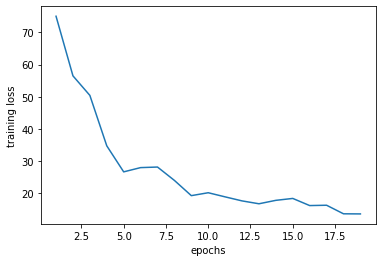

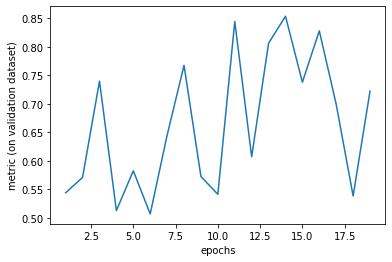

Confusion matrix (rows : real (no_bulls and bulls)  ;  columns : predicted (same) ): 
345  |  9
1447  |  7365

[test] accuracy: 84.115%


[test] bulls_recall: 97.455%

[test] bulls_precision: 19.252%


[test] no_bulls_recall: 83.579%

[test] no_bulls_precision: 99.878%


[test] scoring metric (average recall): 0.905169947385597


In [14]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model_vgg16_norm(pretrained=True, freeze=False)
name_model = "model_vgg16simple_norm_pretrained_batchsize128_recov"
batch_size = 128
trainloader, validationloader, testloader, weight_bulls, weight_no_bulls = audio_importation(shuffle=True)
epochs = 20

final_model = training(model=model, name_model=name_model, epochs=epochs, batch_size=batch_size, device=device)

test(model=final_model)

epoch: 001, batch: 001, loss: 0.772 
epoch: 001, batch: 002, loss: 0.416 
epoch: 001, batch: 003, loss: 0.476 
epoch: 001, batch: 004, loss: 0.254 
epoch: 001, batch: 005, loss: 1.685 
epoch: 001, batch: 006, loss: 0.143 
epoch: 001, batch: 007, loss: 0.291 
epoch: 001, batch: 008, loss: 0.254 
epoch: 001, batch: 009, loss: 0.270 
epoch: 001, batch: 010, loss: 1.027 
epoch: 001, batch: 011, loss: 0.154 
epoch: 001, batch: 012, loss: 1.491 
epoch: 001, batch: 013, loss: 0.144 
epoch: 001, batch: 014, loss: 1.407 
epoch: 001, batch: 015, loss: 0.183 
epoch: 001, batch: 016, loss: 0.253 
epoch: 001, batch: 017, loss: 0.414 
epoch: 001, batch: 018, loss: 0.368 
epoch: 001, batch: 019, loss: 0.095 
epoch: 001, batch: 020, loss: 0.473 
epoch: 001, batch: 021, loss: 0.279 
epoch: 001, batch: 022, loss: 0.185 
epoch: 001, batch: 023, loss: 0.169 
epoch: 001, batch: 024, loss: 0.618 
epoch: 001, batch: 025, loss: 0.092 
epoch: 001, batch: 026, loss: 0.549 
epoch: 001, batch: 027, loss: 0.112 
e

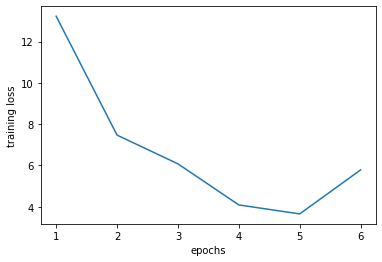

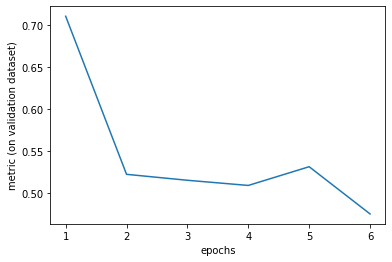

Confusion matrix (rows : real (no_bulls and bulls)  ;  columns : predicted (same) ): 
263  |  91
3384  |  5428

[test] accuracy: 62.088%


[test] bulls_recall: 74.292%

[test] bulls_precision: 7.211%


[test] no_bulls_recall: 61.598%

[test] no_bulls_precision: 98.351%


[test] scoring metric (average recall): 0.6794471896318366


In [15]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model_vgg16_norm(pretrained=True, freeze=False)
name_model = "model_vgg16simple_norm_pretrained_batchsize1024_recov"
batch_size = 1024
trainloader, validationloader, testloader, weight_bulls, weight_no_bulls = audio_importation(shuffle=True)
epochs = 20

final_model = training(model=model, name_model=name_model, epochs=epochs, batch_size=batch_size, device=device)

test(model=final_model)

epoch: 001, batch: 001, loss: 0.642 
epoch: 001, batch: 002, loss: 0.302 
epoch: 001, batch: 003, loss: 0.153 
epoch: 001, batch: 004, loss: 0.272 
epoch: 001 ------------------------------------------------

[train] loss: 2.033

[validation] bulls_recall: 5.322%

[validation] no_bulls_recall: 91.025%

[validation] scoring metric (average recall): 0.4817354624439042

epoch: 002, batch: 001, loss: 0.383 
epoch: 002, batch: 002, loss: 1.580 
epoch: 002, batch: 003, loss: 0.673 
epoch: 002, batch: 004, loss: 0.284 
epoch: 002 ------------------------------------------------

[train] loss: 1.721

[validation] bulls_recall: 15.126%

[validation] no_bulls_recall: 87.537%

[validation] scoring metric (average recall): 0.5133150850297674

epoch: 003, batch: 001, loss: 0.313 
epoch: 003, batch: 002, loss: 0.754 
epoch: 003, batch: 003, loss: 0.131 
epoch: 003, batch: 004, loss: 0.189 
epoch: 003 ------------------------------------------------

[train] loss: 1.500

[validation] bulls_recall: 94

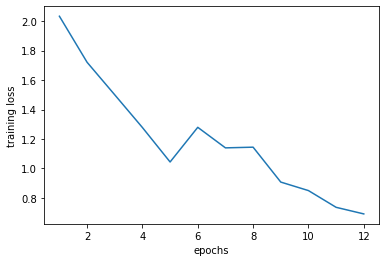

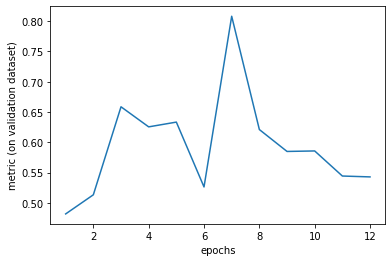

Confusion matrix (rows : real (no_bulls and bulls)  ;  columns : predicted (same) ): 
240  |  114
402  |  8410

[test] accuracy: 94.370%


[test] bulls_recall: 67.795%

[test] bulls_precision: 37.383%


[test] no_bulls_recall: 95.438%

[test] no_bulls_precision: 98.662%


[test] scoring metric (average recall): 0.816163128991405


In [16]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model_vgg16_norm(pretrained=True, freeze=False)
name_model = "model_vgg16simple_norm_pretrained_batchsize8192_recov"
batch_size = 8192
trainloader, validationloader, testloader, weight_bulls, weight_no_bulls = audio_importation(shuffle=True)
epochs = 20

final_model = training(model=model, name_model=name_model, epochs=epochs, batch_size=batch_size, device=device)

test(model=final_model)